In [35]:
import pandas as pd
import numpy as np

from prophet import Prophet
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from sqlalchemy import event
from sqlalchemy import text
import os
from dotenv import load_dotenv
import sys
import warnings

In [2]:
sys.path.append(os.path.abspath('..'))
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
from src.data_tool.connect_db import ConnectDB

In [4]:
db = ConnectDB()
engine = db.get_engine()

DB_USER and DB_PASSWORD are set


In [5]:
tables = db.show_tables()

In [6]:
tables

,Tables
0,capital_structure_debt
1,capital_structure_equity
2,capital_structure_summary
3,company_news
4,financial_metrics
5,financial_ratios
6,fundamentals_annual
7,fundamentals_quarterly
8,identifiers
9,insider_trade


In [7]:
stocks_table = db.read_table('security_daily')

In [8]:
stocks_table.sample(3)

,ticker,datadate,prccd,prchd,prcld,prcod,trfd
3134,AMD,2024-07-22,155.87,156.70,152.545,154.23,1.000274
5298,ADBE,2024-02-06,607.14,626.46,604.670,625.58,1.096237
3213,QCOM,2024-07-15,208.18,209.24,202.785,203.00,1.597373


In [30]:
stocks_table[stocks_table['ticker'] == 'AAPL'][['datadate', 'prccd']]

,datadate,prccd
13,2025-03-18,212.69
21,2025-03-17,214.00
52,2025-03-14,213.49
75,2025-03-13,209.68
84,2025-03-12,216.98
...,...,...
5668,2024-01-08,185.56
5689,2024-01-05,181.18
5703,2024-01-04,181.91
5726,2024-01-03,184.25


In [23]:
data = stocks_table[stocks_table['ticker'] == 'AAPL'][['datadate', 'prccd']]

In [24]:
data.rename(columns={'datadate': 'ds', 'prccd': 'y'}, inplace=True)

In [43]:
# add regressor instead of holiday
earnings_dates = pd.DataFrame({
    'holiday': 'earnings_release',
    'ds': pd.to_datetime(['2024-01-31', '2024-04-30', '2024-07-30', '2024-10-31']), 
    'lower_window': 0,
    'upper_window': 1
})

In [33]:
model = Prophet(
    changepoint_prior_scale=0.15,
    seasonality_prior_scale=15,
    uncertainty_samples=2000,
    holidays=earnings_dates
)

In [34]:
model.add_seasonality(name='weekly', period=7, fourier_order=3)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

In [36]:
data['y'] = np.log(data['y']) 

In [37]:
model.fit(data)

09:42:19 - cmdstanpy - INFO - Chain [1] start processing
09:42:20 - cmdstanpy - INFO - Chain [1] done processing


In [38]:
future = model.make_future_dataframe(periods=30)

In [39]:
forecast = model.predict(future)

In [40]:
forecast['yhat'] = np.exp(forecast['yhat'])
forecast['yhat_lower'] = np.exp(forecast['yhat_lower'])
forecast['yhat_upper'] = np.exp(forecast['yhat_upper'])

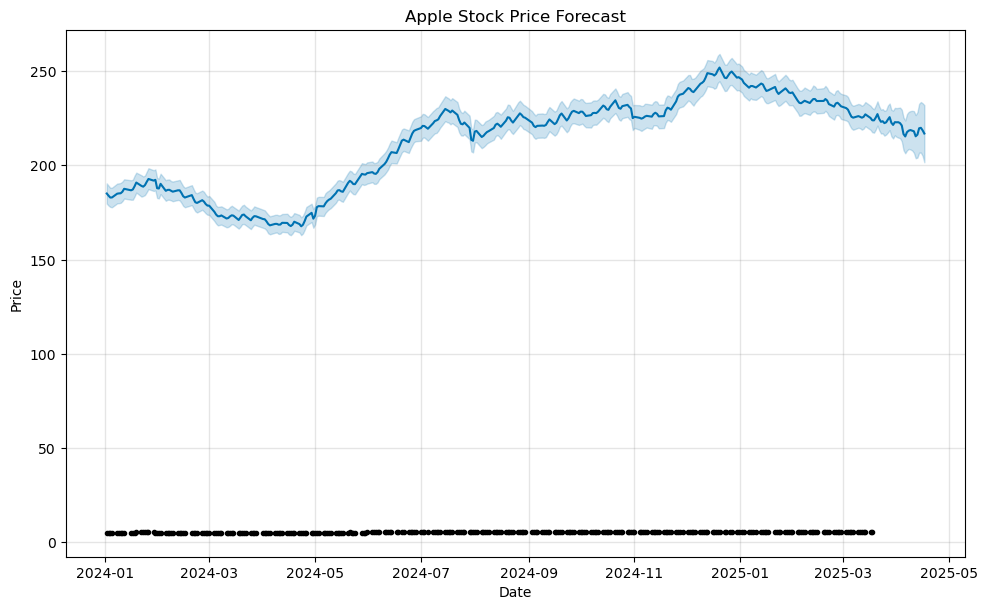

In [41]:
fig = model.plot(forecast)
plt.title("Apple Stock Price Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [42]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

,ds,yhat,yhat_lower,yhat_upper
303,2025-03-19,223.938541,217.403862,229.842027
304,2025-03-20,225.401458,219.013603,231.779192
305,2025-03-21,227.253880,221.146088,234.019862
306,2025-03-22,224.703555,218.648508,231.332209
307,2025-03-23,223.173878,216.955540,229.599916
308,2025-03-24,223.476930,217.011139,229.917230
309,2025-03-25,222.474014,215.819855,228.957205
310,2025-03-26,222.901156,216.420903,229.377065
311,2025-03-27,224.361797,217.482016,231.807936
312,2025-03-28,225.644758,218.734534,232.873736
